In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams.update({'font.size': 15})

### Load data and results

In [31]:
result_file = "../results/mimic_3.pkl"
dataset = "../data/triage_semi_synthetic.csv"
selective = False # Selective observation

In [32]:
if 'mimic' in result_file:
    data = pd.read_csv(dataset, index_col = [0, 1])
    covariates, target = data.drop(columns = ['D', 'Y1', 'Y2', 'YC', 'acuity', 'nurse']), data[['D', 'Y1', 'Y2', 'YC']]

In [33]:
if 'child' in result_file:
    with open('../../data/ChildWelfare/X_preprocess.pkl', 'rb') as handle:
        X, screener_ids, refer_ids, Y_obs, D, Y_serv,Y_sub,colnames = pickle.load(handle)

    # Remove less than 10 observation by experts
    drop_experts = []
    for num in screener_ids:
        if screener_ids.count(num) < 10:
            drop_experts.append(num)

    drop_idx = []
    for index, elem in enumerate(screener_ids):
        if elem in drop_experts:
            drop_idx.append(index)
    
    X = np.delete(X, drop_idx, axis = 0)
    Y_serv = np.delete(Y_serv, drop_idx, axis = 0)
    Y_sub = np.delete(Y_sub, drop_idx, axis = 0)
    Y_obs = np.delete(Y_obs, drop_idx, axis = 0)
    D = np.delete(D, drop_idx, axis = 0)
    refer_ids = np.delete(refer_ids, drop_idx, axis = 0).flatten()

    D = D.reshape((D.shape[0],))
    Y_obs = Y_obs.reshape((Y_obs.shape[0],))

    target = pd.DataFrame({'D': D, 'OOH': Y_obs, 'Substantiated': Y_sub, 'Services': Y_serv,})
    covariates = pd.DataFrame(X)

In [ ]:
results = pickle.load(open(result_file, 'rb'))

### Evaluate 

In [34]:
def evaluate(results, target, p):
    """
        Evaluate dictionary of results

    Args:
        results (_type_): _description_
        target ()
        p (_type_): _description_

    Returns:
        _type_: Dictionary of results
    """
    evaluation = {}
    
    for i, result in enumerate(results): 
        evaluation[i] = pd.DataFrame.from_dict({
            '$f_Y$': compute_metrics(result['Observed'], target, p),
            '$f_h$': compute_metrics(result['Human'], target, p),
            '$f_{hyb}$': compute_metrics(result['Hybrid'], target, p),
            '$f_\mathcal{A}$': compute_metrics(result['Amalgamation'], target, p),
            'Overall prev.': {(tar, 'Precision'): target[tar].loc[result.index].mean() for tar in target.columns}
        })
    
    evaluation = pd.concat(evaluation)
    evaluation.index.rename(['Fold', 'Outcome', 'Metric'], inplace = True)
    return evaluation 

def compute_metrics(predictions, target, p):
    if selective:
        predictions = predictions[target['D'].loc[predictions.index]]

    # Keep top p %
    pred_kept = predictions.nlargest(n = int(p * len(predictions)), keep = 'all')

    metrics = {}
    for tar in target.columns:
        metrics.update({
            (tar, 'Precision'): precision_score(target[tar].loc[pred_kept.index], pred_kept > 0),
            (tar, 'Recall'): recall_score(target[tar].loc[pred_kept.index], pred_kept > 0)
        })
    
    return metrics

In [35]:
evaluation_p = {p: evaluate(results, target, p) for p in np.arange(0.15, 0.45, 0.05)}

### Display

In [36]:
p = 0.25
metric = 'Precision'

In [37]:
colors = ['tab:green', 'tab:red', 'tab:blue', 'tab:orange', 'tab:grey']
patterns = ['/', '-', '\\', '.', '']

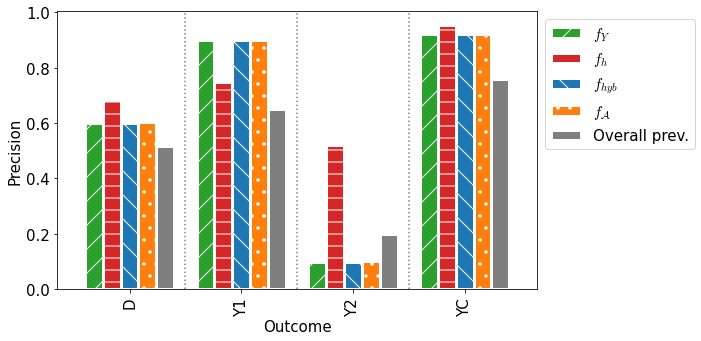

In [38]:
mean = evaluation_p[p].groupby(['Metric', 'Outcome']).mean()
std = evaluation_p[p].groupby(['Metric', 'Outcome']).mean()

ax = mean.loc[metric].plot.bar(edgecolor='white', linewidth = 3, 
                            width = 0.8, figsize = (10, 5), yerr = std,
                            color = colors)

# Add hatch
hue = mean.loc[metric]
hatches = [p for p in patterns for _ in range(len(hue))]
for i, (bar, hatch) in enumerate(zip(ax.patches, hatches)):
    bar.set_hatch(hatch)

# Add separation lines
lines = np.array([bar.get_x() for bar in ax.patches])
for line in lines[-len(hue):-1] + ((lines[1:len(hue)] - lines[-len(hue):-1] + bar.get_width()) / 2):
    plt.axvline(line, ls = ':', color='grey', linestyle='--')

plt.ylabel(metric)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.tight_layout()

In [39]:
all_p = pd.concat(evaluation_p)
all_p.index.rename('Top p %', level = 0, inplace = True)

/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:224: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:224: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/home/vincent/miniconda3/envs/Jupyter/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:2

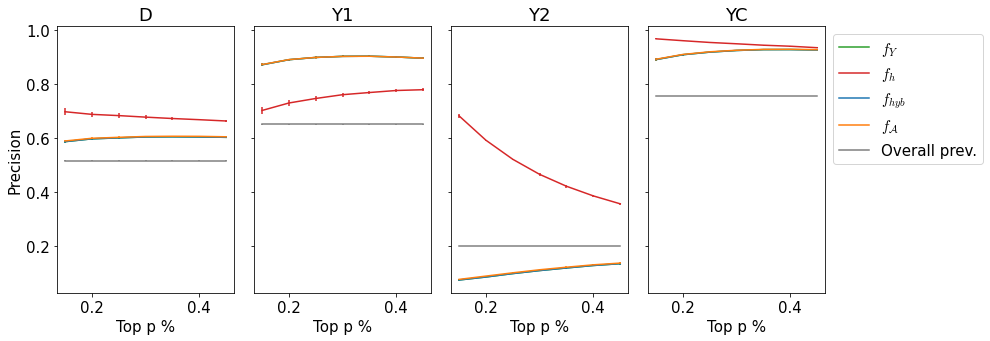

In [40]:
mean = all_p.groupby(['Top p %', 'Metric', 'Outcome']).mean()
std = all_p.groupby(['Top p %', 'Metric', 'Outcome']).std()

selection, ax = mean.index.get_level_values('Metric') == metric, None
for model, color in zip(mean.columns, colors): 
    mean_model = mean[model][selection].droplevel('Metric').unstack('Outcome')
    std_model = std[model][selection].droplevel('Metric').unstack('Outcome')
    ax = mean_model.plot(subplots = True, ax = ax, yerr = std_model, layout=(1, len(hue)), legend = False, sharey = True, figsize = (14,5), color = color)

for ax_outcome, outcome in zip(ax, mean_model.columns):
    ax_outcome.set_title(outcome)

ax[0].set_ylabel(metric)
ax[-1].legend(ax[-1].lines, mean.columns, bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.tight_layout()